# <font color = 'mediumpurple'>**Multilabel Emotion Detection using Stella_en_1.5B_v5**

- The purpose of this notebook is to finetune the `stella_en_1.5B_v5` model for emotion detection on a small dataset.
  - I chose this model from the MTEB leaderboard becuase it is the most lightweight of the top 5 models on that leaderboard and has great results for classification tasks.
  - It is a 1.5B parameter model so it is slightly bigger than the LLama model but has much greater benchmarks.
  - <font color = 'mediumpurple'>***Hugging face MTEB leaderboard link:***</font>
  https://huggingface.co/spaces/mteb/leaderboard

- Based on my past experiences using RNN, BERT, `Gemma-2b`, and `LLama-3.2-1B models` I plan on using a similar strategy to account for the class imbalance present in this dataset.

- This will be done using K fold stratified sampling to create my splits such that the class distribution represents that of the training set.

- In addition I plan on accounting for the class imbalance by calculating some class weights based on how they should be weighted individually within rather than across all classes.

- The training will follow a standard model training process as shown below.

## <font color='mediumpurple'>**Training Plan**

1. **Set the Environment**

2. **Load the Dataset**

3. **Manipulate the Splits of the Dataset**

4. **Load the Pretrained Tokenizer**

5. **Create a Function for the Tokenizer**

6. **Train the Model**
   - 6.1. Download the model
   - 6.2. Download and modify the model's config file
   - 6.3. Compute the metric function (ensuring we account for multilabel, e.g., Binary Cross Entropy)
   - 6.4. Define Training Arguments
   - 6.5. Instantiate the Trainer
   - 6.6. Setup Weights & Biases (WANDB)
   - 6.7. Training and Validation

7. **Model Inference**

# <font color='mediumpurple'>**1. Setting the Environment**</font>



In [ ]:
import sys

# Check if running in Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    # Mount Google Drive with force_remount to avoid mounting issues
    drive.mount('/content/drive', force_remount=True)

    # Set the base path to a Google Drive folder
    base_path = '/content/drive/MyDrive/Colab Notebooks'

    # Install necessary packages
    print("Installing required libraries...")
    !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes -U -qq
    !pip install iterative-stratification -qq

    print("All packages installed successfully.")

Mounted at /content/drive
Installing required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
All packages installed succ

In [ ]:
%load_ext autoreload
%autoreload 2


### <font color='mediumpurple'>**Why Use `ninja-build` for stella_en_1.5B_v5 Multilabel Fine-tuning in Colab**</font>

When fine-tuning a **large language model** like Llama-3.2-1B for **multilabel classification**, especially in Google Colab, optimizing your setup can significantly enhance performance. Here’s why adding `ninja-build` into the workflow can be beneficial:

### <font color='mediumpurple'>**🚀 Speeding Things Up**</font>
- Llama-3.2-1B requires intensive computations, such as **compiling custom layers** and CUDA extensions.
- `ninja-build` focuses on efficiency—it **compiles code significantly faster** than traditional tools like `make`, reducing the overall setup time.

### <font color='mediumpurple'>**🧩 Compatibility with Libraries**</font>
- Key libraries such as `transformers` and `peft` may **automatically utilize** `ninja-build` if it’s available, expediting their initialization process.
- For any **native code or CUDA optimizations** involved in fine-tuning, `ninja-build` can provide a noticeable boost.

### <font color='mediumpurple'>**🛠️ Ensuring Stability**</font>
- Fine-tuning substantial models like Llama-3.2-1B can strain system resources. Leveraging `ninja-build` helps maintain **stability**, minimizing potential compile-time errors or bottlenecks.



In [ ]:
!apt-get install -y ninja-build

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  ninja-build
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 111 kB of archives.
After this operation, 358 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ninja-build amd64 1.10.1-1 [111 kB]
Fetched 111 kB in 1s (125 kB/s)
Selecting previously unselected package ninja-build.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../ninja-build_1.10.1-1_amd64.deb ...
Unpacking ninja-build (1.10.1-1) ...
Setting up ninja-build (1.10.1-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
# Standard libraries and sklearn imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    confusion_matrix,
    multilabel_confusion_matrix,
    precision_score,
    recall_score,
    f1_score
    )

from pathlib import Path
import numpy as np

import re
import gc
import time

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import joblib

# Huggingface, evaluate, wandb, torch, bitsandbytes, transformers
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import (
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    AutoModelForSequenceClassification,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
    set_seed,
    DataCollatorWithPadding
    )

from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model
)

import wandb
from google.colab import userdata
from huggingface_hub import login
import torch.nn as nn
import ast
import torch

In [ ]:
set_seed(42)

In [ ]:
def get_appropriate_dtype():
  if torch.cuda.is_available() and torch.cuda.get_device_capability(0)>(8,0):
    return torch.bfloat16
  return torch.float16

In [ ]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.float16

In [ ]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')

In [ ]:
if hf_token:
  login(token = hf_token)
  print('Login Successful')
else:
  print('Login Unsuccessful - Missing Token')

Login Successful


In [ ]:
if wandb_api_key:
  wandb.login(key = wandb_api_key)
  print('Login Successful')
else:
  print('Login Unsuccessful')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Login Successful


In [ ]:
base_folder = Path(base_path)
data_folder = base_folder/'datasets/emotion_detection_ds'
model_folder = base_folder/'models/nlp_fall_2024/stella_en_1.5B_v5'

model_folder.mkdir(exist_ok = True, parents = True)

# <font color='mediumpurple'>**2. Loading the Dataset**</font>


In [ ]:
train_valid_df = pd.read_csv(data_folder/'train.csv')
train_valid_df.head(5)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
train_val_labels = train_valid_df[['anger',
                                      'anticipation',
                                             'disgust',
                                             'fear',
                                             'joy',
                                             'love',
                                             'optimism',
                                             'pessimism',
                                             'sadness',
                                             'surprise',
                                             'trust']]

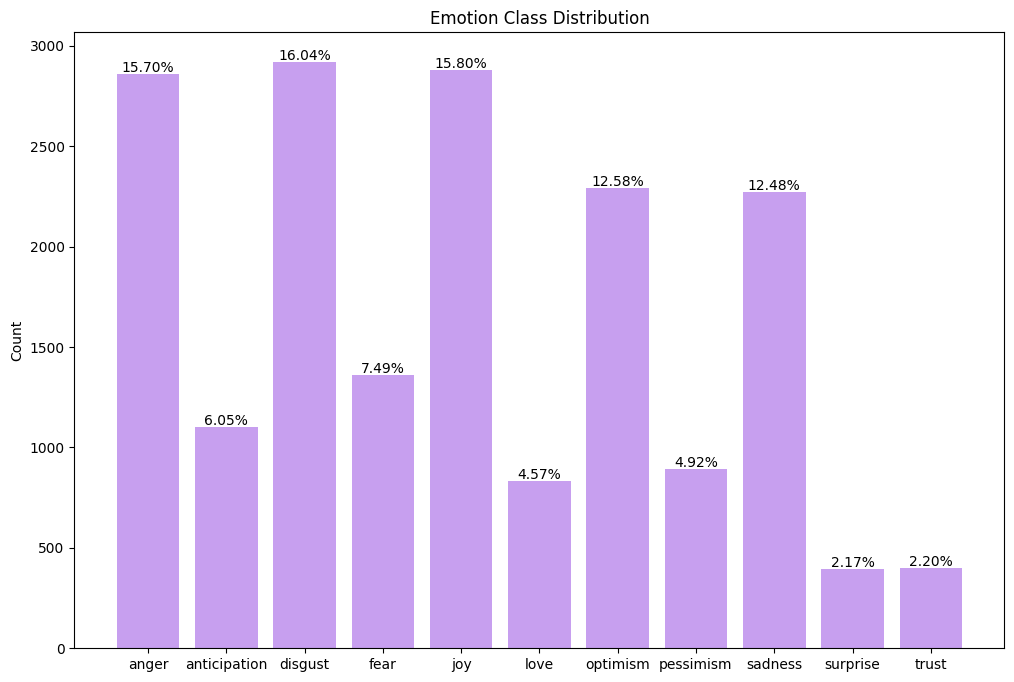

In [ ]:
# getting the label counts for the entire training dataset
label_counts = train_val_labels.sum()

# getting the total sum across all labels
total_count = label_counts.sum()

# getting the percentages based on counts and total
percentages = (label_counts/total_count)*100

# plotting a bar plot
plt.figure(figsize = (12,8))
plt.bar(label_counts.index, label_counts.values, color = '#C79FEF')

for i, (count, pct) in enumerate(zip(label_counts.values, percentages)):
  plt.text(i, count+10, f'{pct:.2f}%', ha = 'center')

plt.title('Emotion Class Distribution')
plt.ylabel('Count')
plt.show()

In [ ]:
label_counts

,0
anger,2859
anticipation,1102
disgust,2921
fear,1363
joy,2877
love,832
optimism,2291
pessimism,895
sadness,2273
surprise,396


# <font color='mediumpurple'>**3. Splitting and Preparing the Data**</font>




In [ ]:
# trying more splits this time, I have been using 10 splits for my other models
mkf = MultilabelStratifiedKFold(n_splits = 15, shuffle = True, random_state = 42)

X = train_valid_df['Tweet'].values
y = train_val_labels.values

# designating the indices for the train and validation sets
for train_index, val_index in mkf.split(X, y):
  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

In [ ]:
train_df = train_valid_df.iloc[train_index] # pulling the train indices from the splits into train_df
val_df = train_valid_df.iloc[val_index] # pulling the validation indices from the splits into val_df


In [ ]:
train_df.head(5)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
train_df.shape

(7210, 13)

In [ ]:
val_df.head(5)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
18,2017-10618,"The bitter the battle, the sweeter the victory...",0,0,0,0,1,0,1,0,0,0,0
21,2017-20349,#NewYork: Several #Baloch &amp; Indian activis...,0,0,0,1,0,0,0,0,1,0,0
23,2017-30807,Your glee filled Normy dry humping of the most...,1,0,1,0,0,0,0,0,0,0,0
29,2017-10966,Autocorrect changes ''em' to 'me' which I rese...,1,0,1,0,0,0,0,0,0,0,0
87,2017-10522,Since the 'update' my @iPhone loses power near...,1,0,1,0,0,0,0,0,1,0,0


In [ ]:
val_df.shape

(514, 13)

### <font color='mediumpurple'>*The plots below shows how the stratified sampling split properly represents the full training set.*</font>

In [ ]:
train_labels = train_df[['anger',
                         'anticipation',
                         'disgust',
                         'fear',
                         'joy',
                         'love',
                         'optimism',
                         'pessimism',
                         'sadness',
                         'surprise',
                         'trust']]

In [ ]:
train_labels.sum()

,0
anger,2664
anticipation,1028
disgust,2727
fear,1272
joy,2685
love,777
optimism,2138
pessimism,835
sadness,2122
surprise,369


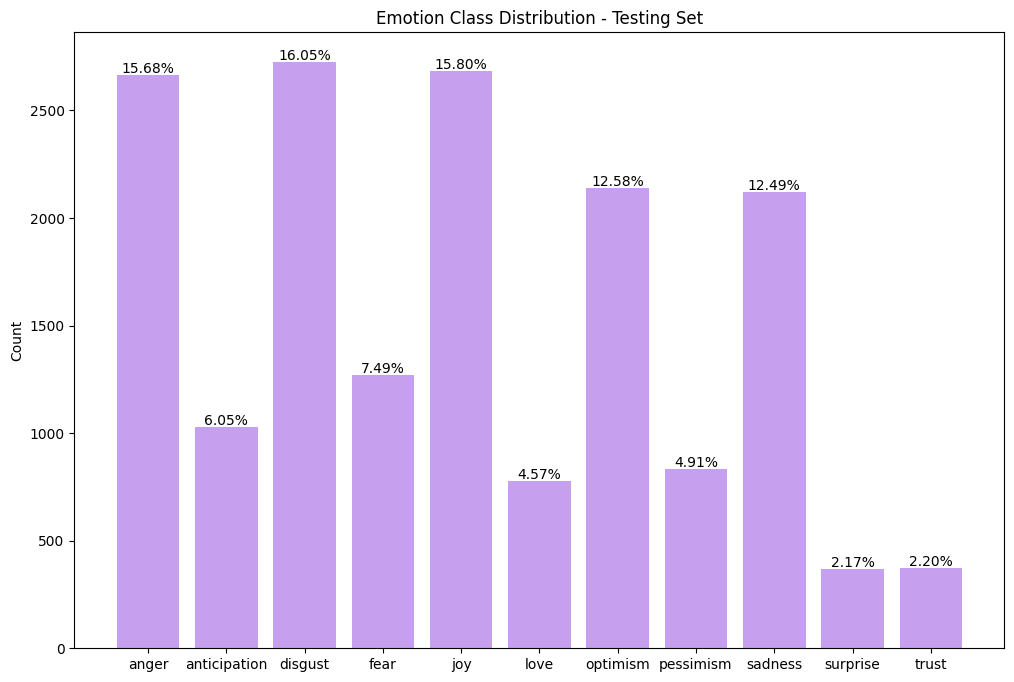

In [ ]:
# getting the counts of classes for the training set
label_counts_t = train_labels.sum()

# getting the total sum of all labels in train
total_count_t = label_counts_t.sum()

# getting the percentages
percentages_t = (label_counts_t/total_count_t)*100

# plotting a bar plot to see the distribution
plt.figure(figsize = (12,8))
plt.bar(label_counts_t.index, label_counts_t.values, color = '#C79FEF')

for i , (count, pct) in enumerate(zip(label_counts_t.values, percentages_t)):
  plt.text(i, count+10, f'{pct:.2f}%', ha = 'center')

plt.title('Emotion Class Distribution - Testing Set')
plt.ylabel('Count')
plt.show()

In [ ]:
val_labels = val_df[['anger',
                         'anticipation',
                         'disgust',
                         'fear',
                         'joy',
                         'love',
                         'optimism',
                         'pessimism',
                         'sadness',
                         'surprise',
                         'trust']]

In [ ]:
val_labels.sum()

,0
anger,195
anticipation,74
disgust,194
fear,91
joy,192
love,55
optimism,153
pessimism,60
sadness,151
surprise,27


<font color = 'mediumpurple'>***The number of observations in the validation set are much smaller than they were when I trained my first RNN model.***

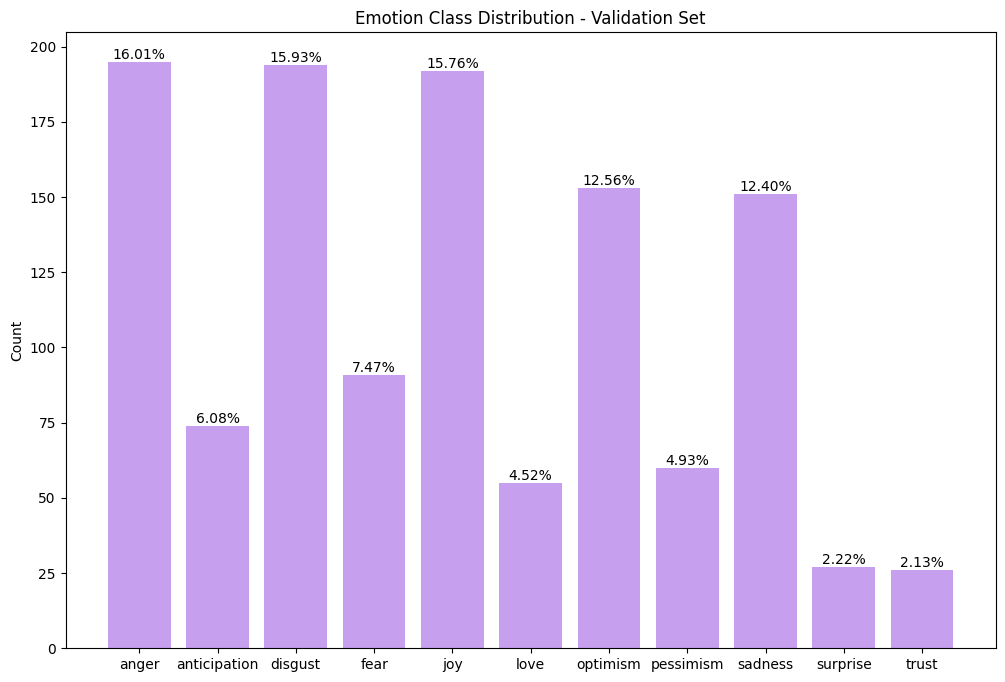

In [ ]:
# getting the validation label_counts as a var
label_counts_v = val_labels.sum()

# getting the total count across the labels
total_count_v = label_counts_v.sum()

# getting the percentages
percentages_v = (label_counts_v/total_count_v)*100

# plotting a bar plot to see the distribution
plt.figure(figsize = (12, 8))
plt.bar(label_counts_v.index, label_counts_v.values, color = '#C79FEF')

for i , (count, pct) in enumerate(zip(label_counts_v.values, percentages_v)):
  plt.text(i, count+1, f'{pct:.2f}%', ha = 'center')

plt.title('Emotion Class Distribution - Validation Set')
plt.ylabel('Count')
plt.show()

<font color = 'mediumpurple'>*Checking the X_train and y_train datatypes*

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
X_train = X_train.tolist()
X_val = X_val.tolist()

In [ ]:
X_val[0]

'The bitter the battle, the sweeter the victory...'

<font color = 'mediumpurple'>***Initial Datasets***

In [ ]:
# making the train dataset object
trainset = Dataset.from_dict({'text':X_train, 'label':y_train})

# making the validset object
validset = Dataset.from_dict({'text':X_val, 'label':y_val})

In [ ]:
trainset

Dataset({
    features: ['text', 'label'],
    num_rows: 7210
})

In [ ]:
trainset['text'][:5]

["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'Whatever you decide to do make sure it makes you #happy.',
 "@Max_Kellerman  it also helps that the majority of NFL coaching is inept. Some of Bill O'Brien's play calling was wow, ! #GOPATS",
 "Accept the challenges so that you can literally even feel the exhilaration of victory.' -- George S. Patton 🐶",
 "My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs"]

In [ ]:
trainset['label'][:5]

[[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
validset

Dataset({
    features: ['text', 'label'],
    num_rows: 514
})

In [ ]:
validset['text'][:2]


['The bitter the battle, the sweeter the victory...',
 '#NewYork: Several #Baloch &amp; Indian activists hold demonstrations outside @UN headquarters demanding Pak to stop exporting #terror into India']

In [ ]:
validset['label'][:2]

[[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]]

<font color = 'mediumpurple'>***Final Dataset***

In [ ]:
# compiling the trainset and validset into a dictionary of dictionaries
train_val = DatasetDict({'train':trainset, 'valid':validset})

In [ ]:
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 7210
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 514
    })
})

In [ ]:
train_val['train'][:5]

{'text': ["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
  'Whatever you decide to do make sure it makes you #happy.',
  "@Max_Kellerman  it also helps that the majority of NFL coaching is inept. Some of Bill O'Brien's play calling was wow, ! #GOPATS",
  "Accept the challenges so that you can literally even feel the exhilaration of victory.' -- George S. Patton 🐶",
  "My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs"],
 'label': [[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
  [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
  [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
  [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [ ]:
train_val['valid'][:2]

{'text': ['The bitter the battle, the sweeter the victory...',
  '#NewYork: Several #Baloch &amp; Indian activists hold demonstrations outside @UN headquarters demanding Pak to stop exporting #terror into India'],
 'label': [[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]]}

# <font color='mediumpurple'>**4. Initializing the Pretrained Tokenizer**</font>


### <font color='mediumpurple'>**Loading the stella_en_1.5B_v5 tokenizer**</font>

### The difference between BERT and a QLoRA model:
- **BERT** (Bidirectional Encoder Representations from Transformers) is a transformer-based model that focuses on two key tasks:
  - **Masked Language Modeling**: BERT randomly masks 15% of tokens in the input sequence, and the model learns to predict the masked tokens, which helps it understand context better.
  - **Next Sentence Prediction**: BERT is trained to predict whether two sentences follow each other in a given pair (e.g., "Is sentence A followed by sentence B?").
  - BERT can handle many different tasks, but these two are the main pretraining objectives.

- **QLoRA** (Quantized Low-Rank Adaptation):
  - QLoRA is an efficient, lightweight approach to fine-tuning LLM's using quantized weights and low-rank adaptors.
    - <font color = 'mediumpurple'>**Quantization**</font> reduces the precision of values by changing the way numbers are used within the model.
    - Standard models use 32-bit floating point numbers to represent the weights of a model.
    - Quantized weights are represented in lower formats such as 8-bit or 4-bit representations.
      - By using fewer bits to store the same data, quantization allows models to:
        - Use less memory
        - Run faster on existing hardware
        - Consume less power, which makes them more efficient for deployment.
    - QLoRA, in particular, uses 4-bit quantization to compress LLM's while maintaining performance at the same time.
      - This means we can fit a large language model into the memory of a 24GB GPU!
    - <font color = 'mediumpurple'>**Low Rank adaptation**</font> works by freezing the original model weights.
      - Instead of taking the entire weight matrix from the original model we fine tune two smaller matrices of weights and add them to the original weight matrix.
      - Example:

        Weights = Main_weights + Small_matrix_A*Small_matrix_B

        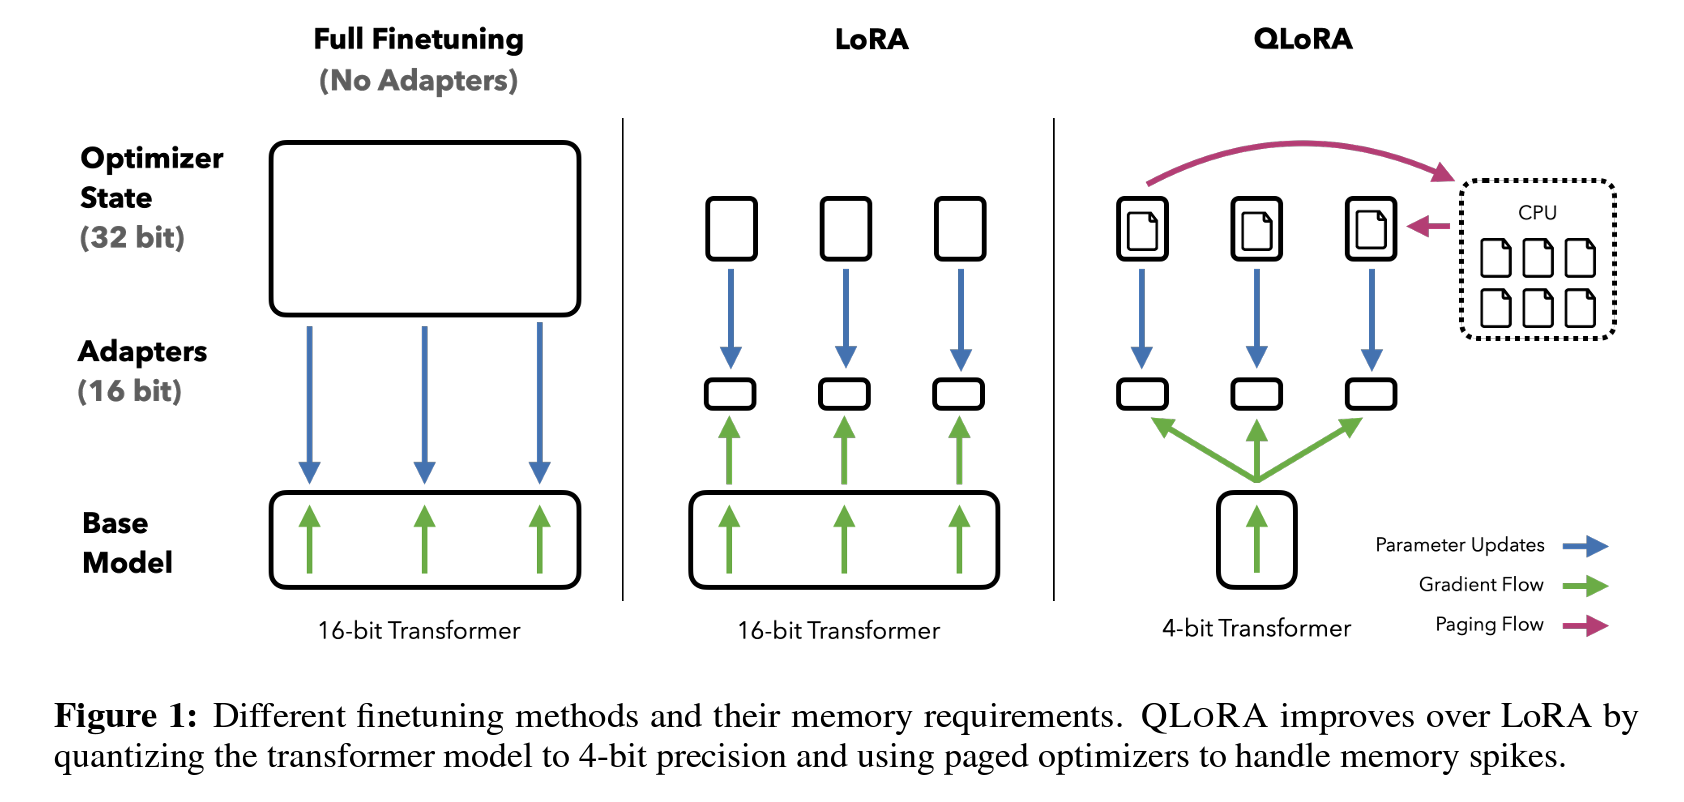

      [Original QLoRA Paper](https://arxiv.org/abs/2305.14314)
      - This allows for a finetuning process that is much smaller and efficient.
      



In [ ]:
def free_gpu_memory():
  """
  Frees up gpu memory after CUDA out of memory error in Colab.

  This function performs the following steps:
  1. Deletes all pytorch objects.
  2. Calls garbage collection to remove unreferenced objects.
  3. Uses torch.cuda.empy_cache() to release cached GPU memory
  4. Waits for a moment to ensure memory is fully released.
  """

  try:
    # Delete all torch tensors to free uo memory
    for obj in list(locals().values()):
      if torch.is_tensor(obj):
        del obj

    # collecting garbage to release any remaining unused memory
    gc.collect()

    # empty the CUDA chache to release GPU memory
    torch.cuda.empty_cache()

    # adding a small delay to allow memory to be fully released
    time.sleep(2)

    print("GPU memory has been freed.")
  except Exception as e:
    print(f"Error while freeing GPU memory: {e}")

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
checkpoint = 'dunzhang/stella_en_1.5B_v5'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/370 [00:00<?, ?B/s]

In [ ]:
tokenizer

Qwen2TokenizerFast(name_or_path='dunzhang/stella_en_1.5B_v5', vocab_size=151643, model_max_length=32768, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

# <font color='mediumpurple'>**5. Creating the Tokenization Function**</font>




In [ ]:
tokenizer.pad_token = '<|endoftext|>'

In [ ]:
def tokenize_fn(batch):
  return tokenizer(text = batch['text'], truncation = True, padding = True, max_length = 512)

### <font color='mediumpurple'>**Remapping labels to float**</font>

In [ ]:
tokenized_dataset = train_val.map(tokenize_fn, batched = True) # mapping the tokenize_fn to each batch
tokenized_dataset = tokenized_dataset.remove_columns(['text']) # removing the full text post tokenization

tokenized_dataset.set_format(type = 'torch') # setting the datatype for the dataset to torch

Map:   0%|          | 0/7210 [00:00<?, ? examples/s]

Map:   0%|          | 0/514 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset = (tokenized_dataset
                     .map(lambda x:{'float_label':x['label'].to(torch.float)}, remove_columns = ['label'])
                     .rename_column('float_label', 'label'))

Map:   0%|          | 0/7210 [00:00<?, ? examples/s]

Map:   0%|          | 0/514 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset['train']['label'][:5]

tensor([[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

# <font color='mediumpurple'>**6. Training the Model**</font>

## <font color='mediumpurple'>**6.1 Downloading the Model**</font>


### <font color = 'mediumpurple'>Optimizing Data Type for My GPU

This function picks the best data type (`dtype`) for my model based on the GPU I'm using. If I’ve got a newer GPU (compute capability `8.0` or higher), it’ll use `bfloat16` for faster and more efficient training. Otherwise, it falls back to `float16`. This helps squeeze the best performance out of whatever hardware I’m running on.

In [ ]:
def get_appropriate_dtype():
  if torch.cuda.is_available() and torch.cuda.get_device_capability(0)>=(8,0):
    return torch.bfloat16
  return torch.float16

In [ ]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True, # loading the model for QLora 4bit
    bnb_4bit_quant_type = 'nf4',  #
    bnb_4bit_use_double_quant = True,
    bnb_4bit_compute_dtype = torch_data_type,
    bnb_4bit_quant_storage = torch_data_type,
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                           num_labels = 11,
                                           problem_type = 'multi_label_classification',
                                           quantization_config = bnb_config,
                                           torch_dtype = torch_data_type,
                                           trust_remote_code = True)

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at dunzhang/stella_en_1.5B_v5 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## <font color='mediumpurple'>**6.2 Modifying the Model Configuration**</font>


In [ ]:
class_names = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [ ]:
config = AutoConfig.from_pretrained(checkpoint)
id2label = {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_:id_ for id_, label_ in enumerate(class_names)}

config.id2label = id2label
config.label2id = label2id

model.config = config
model.config.pad_token_id = tokenizer.pad_token_id

### <font color='mediumpurple'>**Breakdown of `Qwen2Config`**</font>

Here’s an overview of the configuration settings for the **Qwen2 model** using the `stella_en_1.5B_v5` architecture. This breakdown highlights how the **Qwen2 model** is structured and optimized:

- **Model Architecture**: Uses `Qwen2ForCausalLM` and `Qwen2ForSequenceClassification` for **causal language modeling** and **sequence classification** tasks.

---

### <font color='mediumpurple'>**Attention**</font>
- **No attention dropout** applied (`attention_dropout: 0.0`).
- **12 attention heads** with **2 key-value heads**, providing precise attention mechanisms for each layer.
- **Rotary position embeddings** (`rope_theta: 1,000,000.0`) enhance the model's ability to capture positional information over long sequences.

---

### <font color='mediumpurple'>**Tokens & Vocabulary**</font>
- **Token IDs**:
  - `bos_token_id`: 151643 (Beginning of sentence)
  - `eos_token_id`: 151643 (End of sentence)
- **Vocabulary size**: 151,646 tokens

---

### <font color='mediumpurple'>**Model Size & Layers**</font>
- **Hidden size**: 1536
- **Intermediate size**: 8960 (used in the feed-forward layer).
- **Number of layers**: 28
- **Max window layers**: 21

---

### <font color='mediumpurple'>**Activation, Initialization & Normalization**</font>
- **Activation function**: `silu` (Sigmoid Linear Unit).
- **Weight initialization range**: 0.02 to help stabilize training.
- **RMS normalization** applied with epsilon (`rms_norm_eps: 1e-6`) for better stability in deep layers.

---

### <font color='mediumpurple'>**Positional Embeddings & Sequence Handling**</font>
- **Max position embeddings**: 131,072, allowing for extremely long input sequences.
- No **rope scaling** is applied (`rope_scaling: null`).
- **Sliding window** mechanism is disabled (`use_sliding_window: false`).

---

### <font color='mediumpurple'>**Caching & Efficiency**</font>
- **Caching enabled** (`use_cache: true`) to speed up inference and generation tasks.
- Uses **torch_dtype: float32** for computations.

---

### <font color='mediumpurple'>**Multilabel Classification Labels**</font>
- The model is set up for **11 emotion labels**:
  - **anger**, **anticipation**, **disgust**, **fear**, **joy**, **love**, **optimism**, **pessimism**, **sadness**, **surprise**, **trust**.
- Label mapping:
  - `id2label` and `label2id` dictionaries map the labels to their corresponding indices.

---

### <font color='mediumpurple'>**Model Layers Breakdown**</font>
- **Embedding Layer**:
  - `embed_tokens`: Embeds the input tokens into vectors of size 1536.
- **Decoder Layers** (28 layers):
  - Each layer includes:
    - **Self-attention** using `Qwen2SdpaAttention` with 4-bit quantized projections.
    - **MLP block** with 4-bit quantized layers:
      - `gate_proj`, `up_proj`, and `down_proj` layers transform data with an intermediate size of 8960.
    - **Layer normalization** using `Qwen2RMSNorm` before and after the attention blocks.
- **Output Layer**:
  - A final linear layer (`score`) projects the hidden states to the **11 emotion labels**.

---

This configuration ensures that the **Qwen2 model** with `stella_en_1.5B_v5` is optimized for both text generation and sequence classification, leveraging quantization for efficient inference and handling long sequences with rotary embeddings.


In [ ]:
model.config

Qwen2Config {
  "_name_or_path": "dunzhang/stella_en_1.5B_v5",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoModel": "dunzhang/stella_en_1.5B_v5--modeling_qwen.Qwen2Model",
    "AutoModelForCausalLM": "dunzhang/stella_en_1.5B_v5--modeling_qwen.Qwen2ForCausalLM",
    "AutoModelForSequenceClassification": "dunzhang/stella_en_1.5B_v5--modeling_qwen.Qwen2ForSequenceClassification"
  },
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadne

In [ ]:
model

Qwen2ForSequenceClassification(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151646, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear4bit(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear4bit(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear4bit(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear4bit(in_features=1536, out_features=1536, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear4bit(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear4bit(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (nor

### <font color = 'mediumpurple'>**6.2.1 PEFT setup**

In [ ]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [ ]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'score']


['down_proj',
 'o_proj',
 'up_proj',
 'v_proj',
 'q_proj',
 'score',
 'gate_proj',
 'k_proj']

In [ ]:
peft_config = LoraConfig(
    task_type = TaskType.SEQ_CLS,
    r = 128,
    lora_alpha = 256,
    lora_dropout = 0.01,
    bias = 'all',
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'],
)

In [ ]:
lora_model = get_peft_model(model, peft_config)

# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 147,792,384 || all params: 1,691,020,800 || trainable%: 8.7398


In [ ]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Qwen2ForSequenceClassification(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151646, 1536)
        (layers): ModuleList(
          (0-27): 28 x Qwen2DecoderLayer(
            (self_attn): Qwen2SdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=1536, out_features=1536, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1536, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=1536, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
          

In [ ]:
for name, param in lora_model.named_parameters():
  print(f'{name}:{param.requires_grad}')

base_model.model.model.embed_tokens.weight:False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight:False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.bias:True
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight:True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight:True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight:False
base_model.model.model.layers.0.self_attn.k_proj.base_layer.bias:True
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight:True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight:True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight:False
base_model.model.model.layers.0.self_attn.v_proj.base_layer.bias:True
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight:True
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight:True
base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight

## <font color='mediumpurple'>**6.3 Defining the Compute-Metric Function**</font>


In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
accuracy_flatten = evaluate.load('accuracy')
f1 = evaluate.load('f1', 'multilabel')

def compute_metrics(eval_pred):
  # pulling the logits and labels from eval_pred
  logits, labels = eval_pred
  # getting the predictions in integer format
  preds = (logits>0).astype(int)
  # getting the accuracy across each label
  accuracy_label = accuracy_flatten.compute(predictions = preds.flatten(), references = labels.flatten())
  # getting the accuracy across all labels
  accuracy_all = accuracy.compute(predictions = preds, references = labels) # no flattening to get the overall accuracy
  # getting the micro f1 score
  f1_micro = f1.compute(predictions = preds, references = labels, average = 'micro')
  # getting the macro f1 score
  f1_macro = f1.compute(predictions = preds, references = labels, average = 'macro')

  return {
      'f1_micro':f1_micro['f1'],
      'f1_macro':f1_macro['f1'],
      'accuracy_label':accuracy_label['accuracy'],
      'accuracy_all': accuracy_all['accuracy']
  }

## <font color='mediumpurple'>**6.4 Setting Up Training Arguments**</font>


In [ ]:
# Using the same training arguments as I used in my last model
run_name= 'stella-en-1.5B-v5-emotion-exp1'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16
# Configure training parameters
training_args = TrainingArguments(
    seed = 42,  # question of life
    num_train_epochs=4,  # training epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps = 2,  # if you get an out of memory error try changing gradient accumulation and per device batch
    # we need the value to be 32 so we could do 8 batch size and 4 grad accumulation steps
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # Use non-reentrant checkpointing for better stability; avoids errors in complex models but may slightly slow down training

    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-5,  # Increase learning rate for more aggressive updates
    optim='adamw_torch',  # Optimizer

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=50,  # Perform evaluation every 50 training steps for more stable evaluations
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=50,  # Save a model checkpoint every 50 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    metric_for_best_model="eval_f1_macro",  # Continue using F1 Macro as the key metric
    greater_is_better=True,  # A model is 'better' if its F1 Macro score is higher
    lr_scheduler_type = 'reduce_lr_on_plateau',
    warmup_steps = 300, # Warmup in 300 steps

    # Experiment logging configurations
    logging_strategy='steps',
    logging_steps=50,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16 = use_fp16, # set True if torch_data_type is torch.float16
    bf16 = use_bf16, # ste True if torch_data_type is torch.bfloat16
    tf32 = False, # disable tf32 unless you want to use Ampere specific optimization
)

In [ ]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    lora_model.config.use_cache = False  # Disable caching for compatibility

lora_model.config

Qwen2Config {
  "_name_or_path": "dunzhang/stella_en_1.5B_v5",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoModel": "dunzhang/stella_en_1.5B_v5--modeling_qwen.Qwen2Model",
    "AutoModelForCausalLM": "dunzhang/stella_en_1.5B_v5--modeling_qwen.Qwen2ForCausalLM",
    "AutoModelForSequenceClassification": "dunzhang/stella_en_1.5B_v5--modeling_qwen.Qwen2ForSequenceClassification"
  },
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadne

## <font color='mediumpurple'>**6.5 Instantiating the Trainer**</font>


<font color= 'mediumpurple'>***Function: `calculate_class_weights`***

This function calculates class weights for a multilabel classification task, treating each label as if it were a separate binary classification problem. The goal is to adjust for class imbalance **_without having the weights of one class affect the others_**, which can be a common issue when calculating class weights holistically across all labels.

<font color= 'mediumpurple'>***Why this approach?***

In a multilabel setting, each label is independent, and an instance can belong to multiple classes simultaneously. Therefore, treating each label as a separate binary classification problem allows us to adjust the training focus for underrepresented labels without influencing the weights of other labels.

The weights are calculated as follows:
- <span style="color: mediumpurple;">**Positive weight**</span> for each label = (total number of negatives) / (total number of positives).
- This means that if a label is less frequent (i.e., has fewer positive samples), its weight will be higher, encouraging the model to pay more attention to it during training.
- The function outputs these weights as a tensor, which can be used directly in the model's loss function (e.g., using `pos_weight` in `BCEWithLogitsLoss`).

<font color= 'mediumpurple'>***Code Explanation***

- The function first initializes counters for positive and negative samples for each label.
- It iterates through the training dataset to count the number of positives and negatives for each label index.
- Finally, it computes the weight for each label as the ratio of negatives to positives, ensuring that the denominator is at least 1 to avoid division by zero.
- The resulting list of weights is returned as a **<span style="color: mediumpurple;">PyTorch tensor</span>**, which can be used during model training to handle class imbalance.

In [ ]:
def calculate_pos_weights(dataset):
  # intitializing counters for all labels
  num_labels = len(dataset['train']['label'][0])
  total_positives = [0]*num_labels #empty counter list
  total_negatives = [0]*num_labels #empty counter list

  for label_array in dataset['train']['label']:
    for i , label in enumerate(label_array):
      if label ==1:
        total_positives[i]+=1
      else:
        total_negatives[i]+=1
  # calculate the class weight for each label internally based on the positive and negative status
  pos_weight = [total_negatives[i]/max(total_positives[i], 1) for i in range(num_labels)]
  return torch.tensor(pos_weight)

In [ ]:
pos_weights = calculate_pos_weights(tokenized_dataset)

In [ ]:
pos_weights

tensor([ 1.7065,  6.0136,  1.6439,  4.6682,  1.6853,  8.2793,  2.3723,  7.6347,
         2.3977, 18.5393, 18.2781])

In [ ]:
class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs = False, num_items_in_batch = None):
    labels = inputs.pop('labels').float() # getting the labels in float for BCE loss fct
    outputs = model(**inputs)
    logits = outputs.get('logits')

    device = next(model.parameters()).device

    loss_fct = nn.BCEWithLogitsLoss(pos_weight = pos_weights.to(device))
    loss = loss_fct(logits, labels)

    return (loss, outputs) if return_outputs else loss # returns the loss and outputs if return_outputs = True else only the loss

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

In [ ]:
trainer = CustomTrainer(
    model = lora_model,
    args = training_args,
    train_dataset = tokenized_dataset['train'],
    eval_dataset = tokenized_dataset['valid'],
    compute_metrics = compute_metrics,
    tokenizer = tokenizer,
    data_collator = data_collator
)

<ipython-input-110-5b3c88344ff6>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


## <font color='mediumpurple'>**6.6 Configuring Weights & Biases (WANDB)**</font>


In [ ]:
%env WANDB_PROJECT = emotion_stella_1_5B_multilabel

env: WANDB_PROJECT=emotion_stella_1_5B_multilabel


In [ ]:
try:
  # may have an out of memory error
  # lora_model.config.use_cache = False
  trainer.train(resume_from_checkpoint = False)
except RuntimeError as e:
  if 'CUDA out of memory' in str(e):
    print('CUDE out of memory error detected. Freeing GPU memory.')
    free_gpu_memory()
    # can optionally retry the operation after freeing up memory
    # trainer.train()
  else:
    raise e

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
50,0.969900,0.972246,0.520216,0.442444,0.733463,0.058366
100,0.869600,0.800690,0.607224,0.532698,0.786523,0.118677
150,0.791600,0.789002,0.603459,0.536946,0.772904,0.093385
200,0.735500,0.734359,0.638356,0.573668,0.813230,0.114786
250,0.697200,0.731407,0.635520,0.572362,0.812345,0.122568
300,0.628800,0.704368,0.640453,0.576733,0.809162,0.103113
350,0.640300,0.701359,0.647625,0.580197,0.812345,0.093385
400,0.615800,0.694859,0.635864,0.570711,0.800672,0.101167
450,0.621200,0.703456,0.660852,0.589670,0.821189,0.132296
500,0.487300,0.803963,0.660462,0.588117,0.825787,0.140078


In [ ]:
eval_results = trainer.evaluate(tokenized_dataset['valid'])

In [ ]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"],
           "eval_loss": eval_results["eval_loss"],
           "eval_accuracy": eval_results["eval_accuracy_all"]})

In [ ]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset['valid'])

# getting the probabilities from the logits
valid_logits = valid_output.predictions
# converting to probabilities using the sigmoid function
valid_probs = sigmoid(valid_logits)
# getting the labels as integers
valid_labels = np.array(valid_output.label_ids.astype(int))

In [ ]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics

In [ ]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)

In [ ]:
optimal_thresholds

[0.7711541652679443,
 0.5079030990600586,
 0.3902440667152405,
 0.6020081043243408,
 0.44915851950645447,
 0.43339934945106506,
 0.34466516971588135,
 0.6352105140686035,
 0.4975591003894806,
 0.8043184280395508,
 0.909262478351593]

In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [ ]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_micro': 0.7091391733029958,
 'f1_macro': 0.6244532308335017,
 'accuracy_label': 0.8643438273788469,
 'accuracy_all': 0.2178988326848249}

<font color = 'mediumpurple'>*Simple Confusion Matrix*

In [ ]:
valid_preds = (valid_probs>optimal_thresholds).astype(int) # getting the predictions as the values with probs higher than the thresholds
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
mcm

array([[[298,  21],
        [ 47, 148]],

       [[372,  68],
        [ 34,  40]],

       [[250,  70],
        [ 30, 164]],

       [[406,  17],
        [ 19,  72]],

       [[277,  45],
        [ 17, 175]],

       [[418,  41],
        [ 15,  40]],

       [[281,  80],
        [ 20, 133]],

       [[412,  42],
        [ 29,  31]],

       [[284,  79],
        [ 36, 115]],

       [[469,  18],
        [ 17,  10]],

       [[485,   3],
        [ 19,   7]]])

In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='plasma',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='plasma')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats

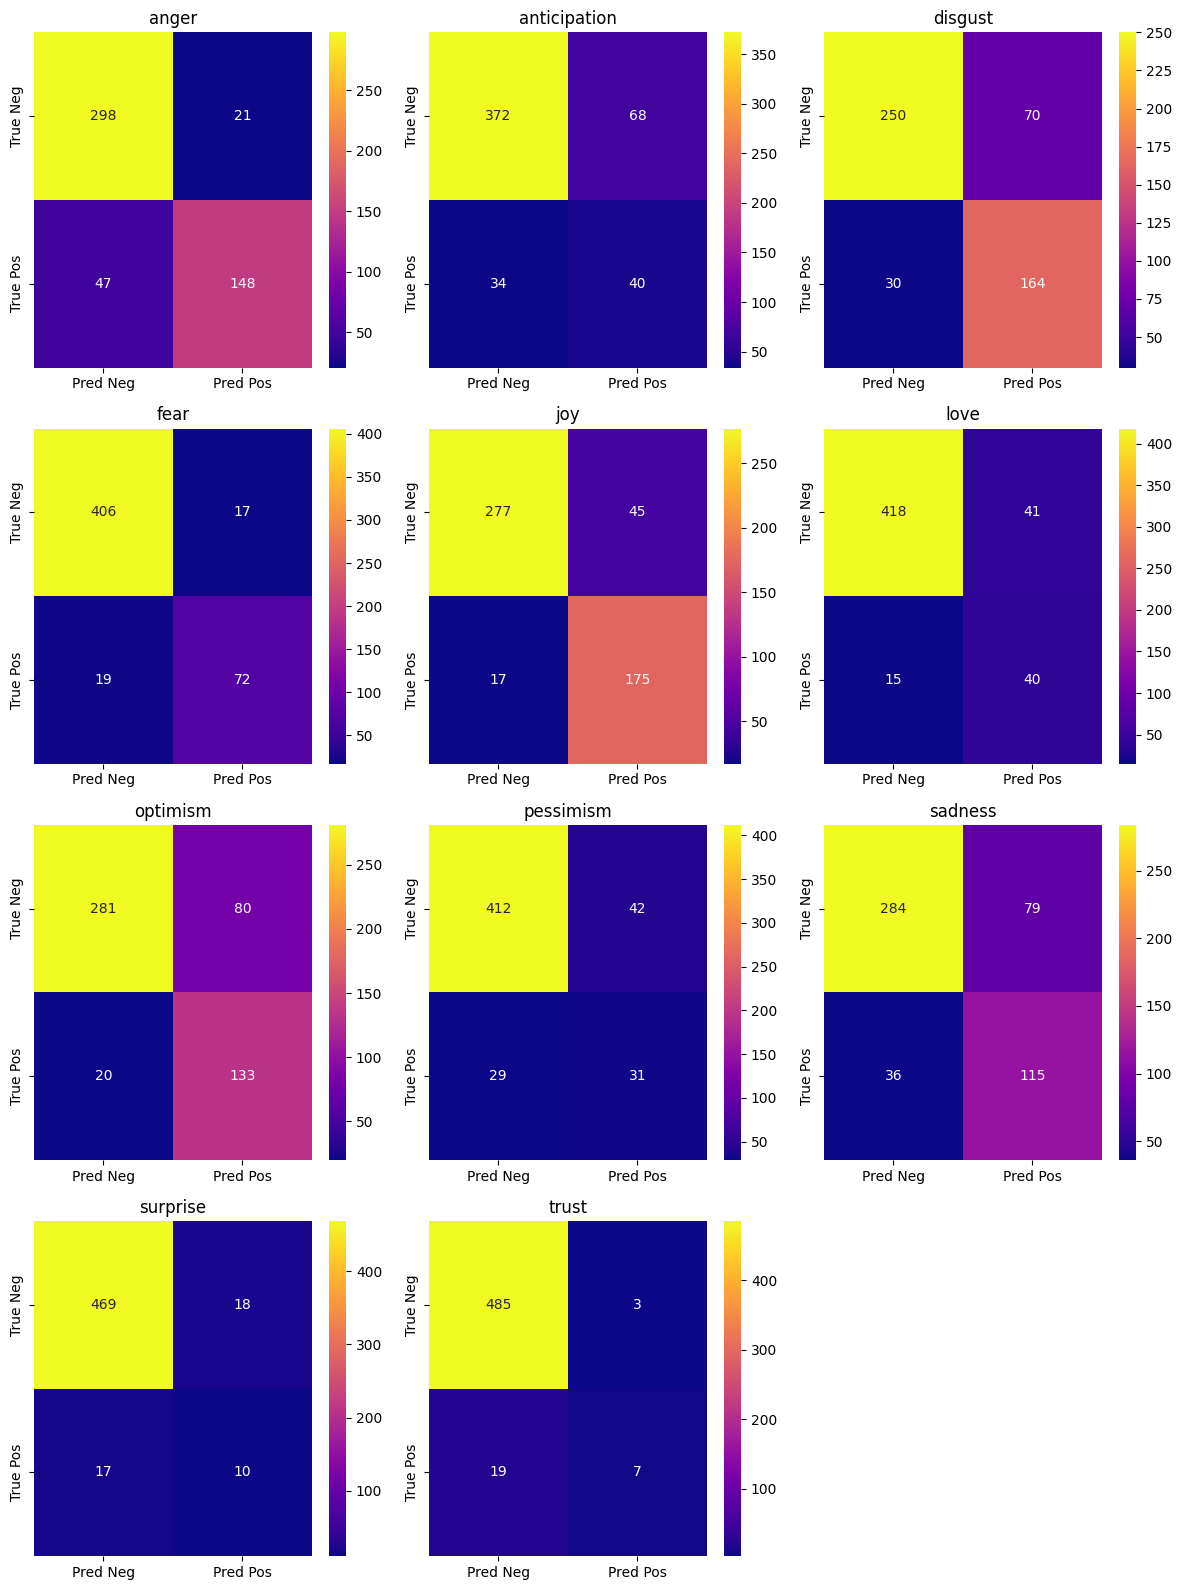

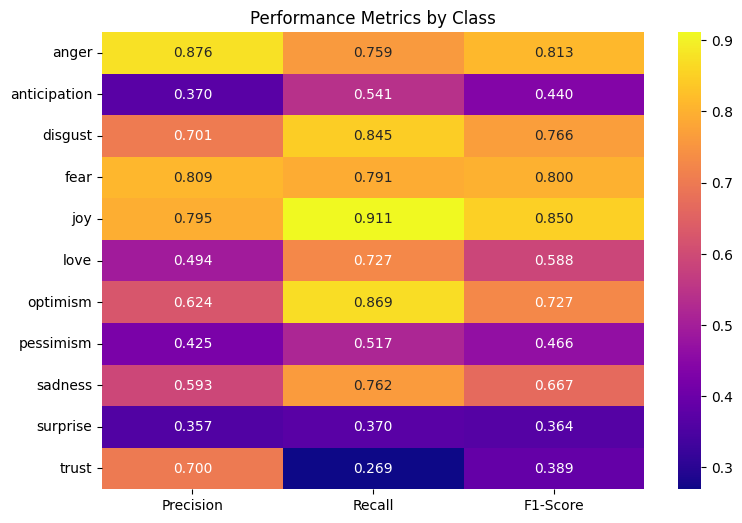

<Figure size 1200x533.333 with 0 Axes>

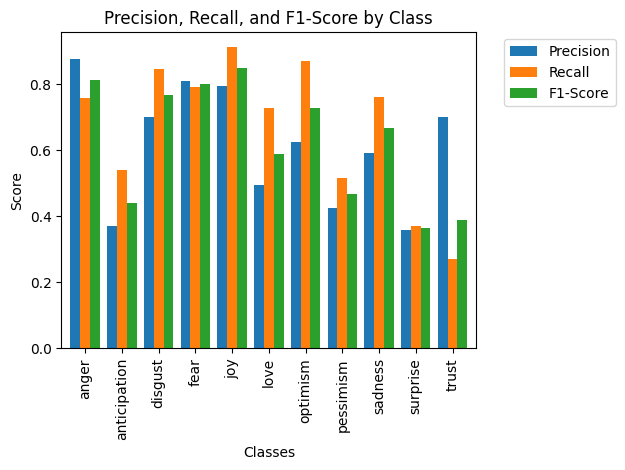

{'macro_avg': {'precision': 0.6131120207520708,
  'recall': 0.6692685301877245,
  'f1': 0.6244532308335017},
 'per_class': {'Precision': {'anger': 0.8757396449704142,
   'anticipation': 0.37037037037037035,
   'disgust': 0.7008547008547008,
   'fear': 0.8089887640449438,
   'joy': 0.7954545454545454,
   'love': 0.49382716049382713,
   'optimism': 0.6244131455399061,
   'pessimism': 0.4246575342465753,
   'sadness': 0.5927835051546392,
   'surprise': 0.35714285714285715,
   'trust': 0.7},
  'Recall': {'anger': 0.7589743589743589,
   'anticipation': 0.5405405405405406,
   'disgust': 0.845360824742268,
   'fear': 0.7912087912087912,
   'joy': 0.9114583333333334,
   'love': 0.7272727272727273,
   'optimism': 0.869281045751634,
   'pessimism': 0.5166666666666667,
   'sadness': 0.7615894039735099,
   'surprise': 0.37037037037037035,
   'trust': 0.2692307692307692},
  'F1-Score': {'anger': 0.8131868131868132,
   'anticipation': 0.43956043956043955,
   'disgust': 0.7663551401869159,
   'fear':

In [ ]:
multilabel_evaluation(y_true = valid_labels, y_pred = valid_preds, class_names = class_names, figsize =(12,8))

#### <font color='mediumpurple'>***Results Analysis***</font>

These results are **among the best so far** across all models I've trained. However, the model shows signs of **overfitting**, suggesting it might not generalize as well to unseen data.

##### <font color='mediumpurple'>**Overall Performance**</font>
- **Macro Average**:
  - Precision: 0.6131, Recall: 0.6693, F1 Score: 0.6245
- The overfitting suggests strong performance on the training set but potential issues with generalization.

##### <font color='mediumpurple'>**Class-wise Insights**</font>
- There’s a **marked improvement** in detecting the **underrepresented classes** like *surprise* and *trust*:
  - **Trust**: Precision 0.7, Recall 0.27, F1 Score 0.39
  - Previously, no patterns were detected in *trust*, so this is a significant enhancement.
  - This raises the question: are these gains due to **class weights** or **threshold fine-tuning**?

##### <font color='mediumpurple'>**Top Performing Classes**</font>
- The model excels in **well-represented classes** like:
  - **Anger**: F1 Score 0.81, **Joy**: F1 Score 0.85, **Disgust**: F1 Score 0.77
- Struggles persist in **underrepresented classes**:
  - **Anticipation**: F1 Score 0.44, **Pessimism**: F1 Score 0.47, **Surprise**: F1 Score 0.36

##### <font color='mediumpurple'>**Next Steps**</font>
- I plan to run **inference on unseen data** to evaluate real-world performance.
- Further experiments will focus on reducing overfitting and refining class predictions, especially in underrepresented categories.

---

Overall, while these results are promising, the focus now shifts to enhancing generalization and reducing overfitting.


<font color = 'mediumpurple'>*Getting the best model checkpoint*

In [ ]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f'The best model checkpoint was saved at step {best_model_checkpoint_step}.')

The best model checkpoint was saved at step 900.


In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')# insert model checkpoint to the left
checkpoint

'/content/drive/MyDrive/Colab Notebooks/models/nlp_fall_2024/stella_en_1.5B_v5/checkpoint-900'

In [ ]:
wandb.finish()

eval/accuracy_all,▁▁▃▅▄▅▅▅▄▅▆▆▅▇▇▇█▇▇██
eval/accuracy_label,▁▁▅▇▆▇▇▇▇▇▇▇▇████████
eval/f1_macro,▁▁▄▆▇▇▇▇█▇███████████
eval/f1_micro,▁▂▅▆▆▇▇▇▇▇▇▇▇████████
eval/loss,███▇▆▃▃▂▂▁▁▁▁▃▂▃▂▄▅▆▅▇▇
eval/runtime,▁▁▃▄▄▄▅▄▃▃▃▃▃▄▃▃▃▄▅▃▃▄█
eval/samples_per_second,██▆▅▅▅▄▅▆▆▆▅▅▅▅▆▅▅▄▅▅▅▁
eval/steps_per_second,██▆▅▅▅▄▅▆▆▆▅▅▅▅▆▅▅▄▅▅▅▁
eval_accuracy,▁
eval_f1_macro,▁
eval_loss,▁


## <font color='mediumpurple'>**7. Performing Model Inference**</font>


In [ ]:
from peft import AutoPeftModelForSequenceClassification, PeftConfig

In [ ]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = '<|endoftext|>'
# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False
model.config.pad_token_id = tokenizer.pad_token_id
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
model.config.id2label = id2label
model.config.label2id = label2id

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at dunzhang/stella_en_1.5B_v5 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenization_qwen.py:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dunzhang/stella_en_1.5B_v5:
- tokenization_qwen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [ ]:
model.config

Qwen2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "dunzhang/stella_en_1.5B_v5",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoModel": "dunzhang/stella_en_1.5B_v5--modeling_qwen.Qwen2Model",
    "AutoModelForCausalLM": "dunzhang/stella_en_1.5B_v5--modeling_qwen.Qwen2ForCausalLM",
    "AutoModelForSequenceClassification": "dunzhang/stella_en_1.5B_v5--modeling_qwen.Qwen2ForSequenceClassification"
  },
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "opti

In [ ]:
# use if needed
# free_gpu_memory()

In [ ]:
custom_pipeline = pipeline(
    task = 'text-classification',
    model = model,
    tokenizer = tokenizer,
    return_all_scores = True,
    function_to_apply = 'sigmoid'
)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForS

In [ ]:
# loading in the test data
test_ds = joblib.load(data_folder/'X_test_cleaned.pkl')

In [ ]:
test_df = pd.DataFrame(test_ds).T # transposing
test_df.rename(columns = {0:'text', 1:'label'}, inplace = True)
print(test_df.head())
print("-"*30)
print(test_df.shape)
print('There are no labels for the entire test set.')

                                                text  \
0  @Adnan__786__ @AsYouNotWish Dont worry Indian ...   
1  Academy of Sciences, eschews the normally sobe...   
2                  I blew that opportunity -__- #mad   
3             This time in 2 weeks I will be 30... 😥   
4  #Deppression is real. Partners w/ #depressed p...   

                                               label  
0  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
1  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
2  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
3  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
4  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
------------------------------
(3259, 2)
There are no labels for the entire test set.


In [ ]:
# performing a test to ensure the prediction pipeline is working
sample = test_df['text'][0]

preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.6233768463134766},
  {'label': 'anticipation', 'score': 0.4945375919342041},
  {'label': 'disgust', 'score': 0.49139487743377686},
  {'label': 'fear', 'score': 0.9830850958824158},
  {'label': 'joy', 'score': 0.2885690927505493},
  {'label': 'love', 'score': 0.002800926798954606},
  {'label': 'optimism', 'score': 0.7386690378189087},
  {'label': 'pessimism', 'score': 0.0059110685251653194},
  {'label': 'sadness', 'score': 0.04535258188843727},
  {'label': 'surprise', 'score': 6.605214002775028e-05},
  {'label': 'trust', 'score': 0.4368622601032257}]]

In [ ]:
def get_labels(pipeline_output, optimal_thresholds):
  positive_labels = []

  for pred_set in pipeline_output:
    # getting the scores for all labels
    scores = [pred['score'] for pred in pred_set]
    labels = [pred['label'] for pred in pred_set]

    # getting the positions where the score > optimal threshold
    sample_positives = [
        label for label, score, threshold in zip(labels, scores, optimal_thresholds)
        if score > threshold
    ]

    positive_labels.append(sample_positives)

  return positive_labels

In [ ]:
# paste optimal thresholds here if needed from above

In [ ]:
# performing a test to ensure the prediction pipeline is working
sample = test_df['text'][0]

preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.6233768463134766},
  {'label': 'anticipation', 'score': 0.4945375919342041},
  {'label': 'disgust', 'score': 0.49139487743377686},
  {'label': 'fear', 'score': 0.9830850958824158},
  {'label': 'joy', 'score': 0.2885690927505493},
  {'label': 'love', 'score': 0.002800926798954606},
  {'label': 'optimism', 'score': 0.7386690378189087},
  {'label': 'pessimism', 'score': 0.0059110685251653194},
  {'label': 'sadness', 'score': 0.04535258188843727},
  {'label': 'surprise', 'score': 6.605214002775028e-05},
  {'label': 'trust', 'score': 0.4368622601032257}]]

In [ ]:
results = get_labels(preds, optimal_thresholds)
results

[['disgust', 'fear', 'optimism']]

In [ ]:
def get_predictions_from_pipeline(pipeline_output, model, df_test_ids, optimal_thresholds):
    """
    This function processes the pipeline output using custom thresholds and generates predictions
    for the test dataset, returning a final DataFrame with test IDs and predicted labels.

    Parameters:
    - pipeline_output: The output from the custom pipeline (containing the scores)
    - model: The model used for generating the pipeline output (to get the id2labels)
    - df_test_ids: A DataFrame containing the test IDs
    - optimal_thresholds: A list of optimal thresholds for each label

    Returns:
    - df_pred_final: A pandas DataFrame with test IDs and their corresponding label predictions in binary format
    - positive_labels_list: A list of positive labels for each instance to compare results.
    """
    # 1. Get positive labels using the custom thresholds
    positive_labels_list = get_labels(pipeline_output, optimal_thresholds)

    # 2. Prepare binary predictions using the optimal thresholds
    binary_predictions = []
    for pred_set in pipeline_output:
        scores = [pred['score'] for pred in pred_set]
        binary_preds = [1 if score > threshold else 0 for score, threshold in zip(scores, optimal_thresholds)]
        binary_predictions.append(binary_preds)

    # 3. Convert the binary predictions to a DataFrame
    # Map the model config labels
    class_labels = [model.config.id2label[i] for i in range(len(model.config.id2label))]
    df_predictions = pd.DataFrame(binary_predictions, columns=class_labels)

    # 4. Concatenate test IDs with predictions
    df_pred_final = pd.concat([df_test_ids.reset_index(drop=True), df_predictions], axis=1)

    # 5. Set the index of the final DataFrame to be the ID column
    df_pred_final = df_pred_final.set_index('ID')

    return df_pred_final, positive_labels_list


In [ ]:
test_ids = joblib.load(data_folder/'test_ids.pkl')
test_ids.head()

,ID
0,2018-01559
1,2018-03739
2,2018-00385
3,2018-03001
4,2018-01988


<font color = 'mediumpurple'>***Prepping the test_df to make predictions***

In [ ]:
test_ds = test_df.drop(columns = {'label'}) # dropping the missing labels from the dataset

In [ ]:
test_ds

,text
0,@Adnan__786__ @AsYouNotWish Dont worry Indian ...
1,"Academy of Sciences, eschews the normally sobe..."
2,I blew that opportunity -__- #mad
3,This time in 2 weeks I will be 30... 😥
4,#Deppression is real. Partners w/ #depressed p...
...,...
3254,shaft abrasions from panties merely shifted to...
3255,@lomadia heard of Remothered? Indie horror gam...
3256,All this fake outrage. Y'all need to stop 🤣
3257,Would be ever so grateful if you could record ...


In [ ]:
test_ds = Dataset.from_pandas(test_ds)

In [ ]:
test_ds['text'][:3]

['@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell',
 'Academy of Sciences, eschews the normally sober tone of scientific papers and calls the massive loss of wildlife a “biological annihilation',
 'I blew that opportunity -__- #mad']

In [ ]:
# input for the function written above
pipeline_output = custom_pipeline(test_ds['text'][:]) # running the prediction pipeline on all documents

In [ ]:
df_pred_final, positive_labels_list = get_predictions_from_pipeline(pipeline_output = pipeline_output,
                                                                    model = model,
                                                                    df_test_ids = test_ids,
                                                                    optimal_thresholds = optimal_thresholds)

In [ ]:
df_pred_final.sum()

,0
anger,949
anticipation,631
disgust,1330
fear,480
joy,1613
love,811
optimism,1580
pessimism,420
sadness,1087
surprise,129


In [ ]:
df_pred_final.shape

(3259, 11)

In [ ]:
df_pred_final.to_csv(base_folder/'final_predictions_stella_en_1.5B_v5.csv')